<a href="https://colab.research.google.com/github/serciex/lane-change/blob/main/V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing Prerequisites

In [16]:
!pip install pygame
!pip install highway-env

Testing

In [17]:
#Import Libraries
from os import truncate
import math
import gymnasium
import highway_env
from matplotlib import pyplot as plt
import pygame
import numpy as np


from IPython.display import Image, display
from collections import deque
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
%matplotlib inline

Environment Definition

In [18]:
# Configure Environment Conditions
config = {
    "lanes_count": 3,
    "lane_width": 3.75,
    "observation": {
        "type": "Kinematics",
        "features": ["x", "y", "vx", "vy", "heading", "lat_off"]
    },
    "action": {"type": "ContinuousAction"},"ego_spawn_random": True,
    "policy_frequency": 10,
}
env = gymnasium.make('highway-v0', render_mode='rgb_array', config=config)
frames = []

# Action Setup
highway_env.envs.common.action.ContinuousAction(env, lateral=True,
                                                longitudinal=True)

In [19]:
# Environment Manager
class ENV(env.__class__):
  """
  s = (v,a,x,y,thetha,id,w,c) ∈ S

  Lateral Agent State:
  Obs Data:
  x = vehicle x position (x)
  y = vehicle y position (y)
  v = vehicle speed (vx)
  thetha = yaw angle (heading)

  Input:
  a = longitudinal acceleration (longitudinal_control)
  id = target lane id
  w = lane width
  c = road curvature

  Extra Data:
  vy = lateral rate (vy)
  delta_lat_deviation = change in lateral deviation (lat_off)

  """
  def __init__(self, obs,a):
    self.obs = obs
    self.a = a

  def ego_state_idm(self):
      ax, ay, avx, avy, athetha, _ = self.obs[0]
      self._ego_state_idm = {"x": ax, "y": ay, "vx": avx,"thetha": athetha,
                         "longitudinal_acceleration":self.a}

      return self._ego_state_idm

  def ego_state_agent(self,target_id):
      ax, ay, avx, avy, athetha, _ = self.obs[0]
      vehicle = env.unwrapped.vehicle

      # Control Parameters
      self.id = target_id

      # Environment Parameters
      self.s,_ = vehicle.lane.local_coordinates(vehicle.position)
      self.w = vehicle.lane.width
      self.c = vehicle.lane.heading_at(np.clip(
          vehicle.lane.local_coordinates(vehicle.position)[0],
          0, vehicle.lane.length))
      self.v = math.sqrt(avx**2+avy**2)

      self._ego_state_agent = {"x": ax, "y": ay, "vx": self.v,"thetha": athetha,
                         "lane_width":self.w,"lane_id":self.id,
                         "self_curvature":self.c,
                         "longitudinal_acceleration":self.a}

      return self._ego_state_agent

  def longitudinal_lead_state(self):
    # Lead State Parameters on the same Lane (5 columns: presence, x, y, vx, vy)
    ego_vehicle = env.unwrapped.vehicle
    lead_vehicle = env.unwrapped.road.neighbour_vehicles(ego_vehicle, lane_index=ego_vehicle.lane_index)[0]
    if lead_vehicle:
      gap = lead_vehicle.position[0] - ego_vehicle.position[0]
      delta_velocity = ego_vehicle.velocity[0] - lead_vehicle.velocity[0]
      self.longitudinal_lead_state = {"x": gap, "vx": delta_velocity}

    else:
      self.longitudinal_lead_state = {"x": 10, "vx": 0}

    return self.longitudinal_lead_state

  #Reward Function
  def reward_function(self, obs_old, obs_new, target_id, w1=1, w2=1, w3=0.05):
    """
    Reward Function:

    Acceleration Reward: r_acce = w1*f_acce(a_yaw)
    a_yaw = lateral acceleration (self.action)

    Rate Reward: r_rate = w2*f_rate(w_yaw)
    w_yaw = lateral rate (vy)

    Time Reward: r_time = w3*f_time (delta_lat_deviation)
    delta_lat_deviation = change in lateral deviation (self.lat_off)

    Reward = Cummulative Sum of r_acce + Cummulative Sum of r_rate + Cummulative Sum of r_time

    """

    self.target_id = ("0","1",target_id)
    target_lane_object = env.unwrapped.road.network.get_lane(self.target_id)
    vehicle_s, _ = env.unwrapped.vehicle.lane.local_coordinates(env.unwrapped.vehicle.position)
    _ , self.delta_lat_deviaton = target_lane_object.local_coordinates(env.unwrapped.vehicle.position)

    obs = obs_new[0]
    obs_old = obs_old[0]

    w_yaw = (obs[0] * obs[3] - obs[1] * obs[2]) / (obs[0]**2 + obs[1]**2 + 1e-8)
    w_yaw_old = (obs_old[0] * obs_old[3] - obs_old[1] * obs_old[2]) / (obs_old[0]**2 + obs_old[1]**2 + 1e-8)

    self.w_acce = (w_yaw-w_yaw_old)*env.unwrapped.config['policy_frequency']

    # Acceleration Reward
    acce_reward = -1*abs(self.w_acce)

    # Rate Reward
    rate_reward = -1*abs(w_yaw)

    # Time Reward
    time_reward = -0.05 * abs(self.delta_lat_deviaton)

    # Overall Reward
    self.reward = w1*acce_reward + w2*rate_reward + w3*time_reward

    return [self.reward, acce_reward, rate_reward, time_reward]

  #Acceleration to Steering angle
  def steering_angle(self, agent_action,L=1):
    """
    Steering Angle: theta = atan(a_yaw/v^2)
    a_yaw = lateral acceleration (agent_action)
    v = vehicle speed (vx)
    """
    self.angle = math.atan(L*agent_action/self.ego_state_idm()['vx']**2)

    return self.angle

Agent Defintion

In [20]:
class Agent(nn.Module):
  """
  s = (x, y, vx, vy, thetha, lane_width, lane_id, self_curvature, longitudinal_acceleration) ∈ S

  Lateral Agent State:
  x = vehicle x position
  y = vehicle y position
  vx = vehicle speed (longitudinal)
  thetha = yaw angle (heading)
  lane_width = width of the lane
  lane_id = target lane id
  self_curvature = road curvature at the vehicle's position
  longitudinal_acceleration = vehicle longitudinal acceleration
  """
  def __init__(self, state_dim):
    super(Agent, self).__init__()
    self.state_dim = state_dim
    # Define Network A & C
    self.networkA = nn.Sequential(
        nn.Linear(self.state_dim, 100),
        nn.Linear(100, 1),
        nn.Softplus()
    )
    self.networkC = nn.Sequential(
        nn.Linear(self.state_dim + 1, 100),
        nn.ReLU(),
        nn.Linear(100, 1),
    )

    # Define Network B
    self.networkB1 = nn.Sequential(
        nn.Linear(self.state_dim, 150),
        nn.ReLU(),
        nn.Linear(150, 1),
    )
    self.networkB2 = nn.Sequential(
        nn.Linear(self.state_dim, 150),
        nn.ReLU(),
        nn.Linear(150, 1),
    )
    self.networkB3 = nn.Sequential(
        nn.Linear(self.state_dim, 150),
        nn.ReLU(),
        nn.Linear(150, 1),
    )

  def forward(self, state, a, terminal):
    """
    Q(s,a) = A(s)*(B(s)-a)^2 + C(s)
    """
    if isinstance(state, dict):
      state_tensor = torch.tensor(
          [state[key] for key in ['vx', 'longitudinal_acceleration', 'x', 'y', 'thetha', 'lane_id', 'lane_width', 'self_curvature']],
          dtype=torch.float32
      ).unsqueeze(0)
    else:
        self.state = state
    # Use a directly if it's already a tensor
    self.a = a if isinstance(a, torch.Tensor) else torch.tensor([[a]], dtype=torch.float32)
    self.terminal_condition = terminal if isinstance(terminal, torch.Tensor) else torch.tensor([[terminal]], dtype=torch.float32)

    # Output of the Networks
    self.A = self.networkA(self.state)
    self.C = self.networkC(torch.concat((self.state, self.terminal_condition), dim=1))
    self.B = torch.max(self.networkB1(self.state) * self.networkB2(self.state),
                         self.networkB3(self.state))

    # Q-function Approximation
    q_value = -self.A * ((self.B - self.a) ** 2) + self.C

    return q_value

  def action(self, state):
      # Convert it to a tensor
      if isinstance(state, dict):
          state_tensor = torch.tensor(
              [state[key] for key in ['vx', 'longitudinal_acceleration', 'x', 'y', 'thetha', 'lane_id', 'lane_width', 'self_curvature']],
              dtype=torch.float32
          ).unsqueeze(0)
      else:
          state_tensor = state
      self.state = state_tensor
      self.B = torch.max(self.networkB1(self.state) * self.networkB2(self.state),
                         self.networkB3(self.state))
      return self.B

Experience Buffer

In [21]:
from collections import deque # Ensure imported

class Experience_Buffer():
    """
    Stores transitions as tuples of NumPy arrays (state_vec, action_vec, reward_vec, next_state_vec, terminal_vec).
    """
    def __init__(self, buffer_size):
        self.buffer_size = buffer_size
        self.buffer = deque(maxlen=self.buffer_size)

    def add(self, state_vec, action, reward, next_state_vec, terminal_condition):
        state_np = np.asarray(state_vec, dtype=np.float32)
        next_state_np = np.asarray(next_state_vec, dtype=np.float32)
        action_np = np.asarray([action], dtype=np.float32)
        reward_np = np.asarray([reward], dtype=np.float32)
        terminal_np = np.asarray([float(terminal_condition)], dtype=np.float32)

        self.transition = (state_np, action_np, reward_np, next_state_np, terminal_np)
        self.buffer.append(self.transition)

    def sample_experience(self, batch_size, device):
        """ Samples batch and returns Tensors. """
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, terminals = zip(*batch)

        states_np = np.stack(states)
        actions_np = np.stack(actions)
        rewards_np = np.stack(rewards)
        next_states_np = np.stack(next_states)
        terminals_np = np.stack(terminals)

        # Convert final batch arrays to Tensors
        states_tensor = torch.tensor(states_np, dtype=torch.float32, device=device)
        actions_tensor = torch.tensor(actions_np, dtype=torch.float32, device=device)
        rewards_tensor = torch.tensor(rewards_np, dtype=torch.float32, device=device)
        next_states_tensor = torch.tensor(next_states_np, dtype=torch.float32, device=device)
        terminals_tensor = torch.tensor(terminals_np, dtype=torch.float32, device=device)

        return states_tensor, actions_tensor, rewards_tensor, next_states_tensor, terminals_tensor

    def size(self):
        return len(self.buffer)

Lateral Controller (Gap Checker)

In [22]:
import numpy as np

class Gap_Controller(env.__class__):
    def __init__(self, obs=None, following_gap_threshold=10.0):
        # Optionally store an initial observation if provided.
        if obs is not None:
            self.obs = obs
        # Threshold for safety gap with the following vehicle
        self.following_gap_threshold = following_gap_threshold

    def lane_checker(self):
        """
        Determines which adjacent lane offers the safest gap for a lane change.
        It examines the current lane, the lane to the left, and the lane to the right,
        returning the lane index that has the largest safe front gap available.
        In addition, if the gap with the following vehicle in the target lane is below the safety
        threshold, the lane change is aborted and the current lane is chosen.

        Returns:
            int: The target lane index (the lane with the largest safe gap, or the current lane)
                 if the candidate lane's following vehicle gap is unsafe.
        """
        lane_number = len(env.unwrapped.road.network.lanes_list())
        ego = env.unwrapped.vehicle

        # Initialize front gap values with a default that indicates an unsafe or non-existent gap.
        gap_current_front = -float('inf')
        gap_right_front = -float('inf')
        gap_left_front = -float('inf')

        # Initialize following gap values (gap between ego and the vehicle behind)
        gap_current_follower = float('inf')
        gap_right_follower = float('inf')
        gap_left_follower = float('inf')

        # Get vehicle neighbours in current lane:
        neighbours_current = env.unwrapped.road.neighbour_vehicles(ego, ego.lane_index)
        # neighbours_current[0] is the vehicle ahead and [1] is the following vehicle.
        if neighbours_current:
            if neighbours_current[0]:
                gap_current_front = neighbours_current[0].position[0] - ego.position[0]
            if len(neighbours_current) > 1 and neighbours_current[1]:
                gap_current_follower = ego.position[0] - neighbours_current[1].position[0]

        # Compute the left and right lane indices.
        current_lane = list(ego.lane_index)
        if current_lane[2] > 0:
            lane_left = (current_lane[0], current_lane[1], current_lane[2] - 1)
        else:
            lane_left = ego.lane_index

        if current_lane[2] < (lane_number - 1):
            lane_right = (current_lane[0], current_lane[1], current_lane[2] + 1)
        else:
            lane_right = ego.lane_index

        # Retrieve neighbour vehicles for the right lane.
        neighbours_right = env.unwrapped.road.neighbour_vehicles(ego, lane_index=lane_right)
        if neighbours_right:
            if neighbours_right[0]:
                gap_right_front = neighbours_right[0].position[0] - ego.position[0]
            if len(neighbours_right) > 1 and neighbours_right[1]:
                gap_right_follower = ego.position[0] - neighbours_right[1].position[0]

        # Retrieve neighbour vehicles for the left lane.
        neighbours_left = env.unwrapped.road.neighbour_vehicles(ego, lane_index=lane_left)
        if neighbours_left:
            if neighbours_left[0]:
                gap_left_front = neighbours_left[0].position[0] - ego.position[0]
            if len(neighbours_left) > 1 and neighbours_left[1]:
                gap_left_follower = ego.position[0] - neighbours_left[1].position[0]

        # Compare the front gaps: current, right, and left.
        front_gaps = [gap_current_front, gap_right_front, gap_left_front]
        best_index = np.argmax(front_gaps)

        # Determine the target lane index based on the best candidate.
        # best_index: 0 => current lane, 1 => right lane, 2 => left lane.
        if best_index == 1:
            candidate_lane = lane_right
            candidate_follower_gap = gap_right_follower
        elif best_index == 2:
            candidate_lane = lane_left
            candidate_follower_gap = gap_left_follower
        else:
            candidate_lane = ego.lane_index
            candidate_follower_gap = gap_current_follower  # in current lane, we don't enforce follower gap condition

        # Check if the candidate lane (if different from the current lane)
        # meets the follower gap condition.
        if candidate_lane != ego.lane_index:
            if candidate_follower_gap < self.following_gap_threshold:
                # The follower gap is too small; do not change lanes.
                target_lane_id = ego.lane_index[2]
            else:
                target_lane_id = candidate_lane[2]
        else:
            target_lane_id = ego.lane_index[2]

        return target_lane_id


Longitudinal Controller

In [23]:
class IDM():
    ''' Intelligent Driving Model for Longitudinal Control

    Control parameters:
      a: maximum acceleration
      b: comfortable deceleration
      delta: acceleration exponent
      T: safe time headway

    Parameters:
      s0: minimum gap
      v0: desired speed

      a (Maximum Acceleration): How fast the vehicle can speed up (m/s²).
      b (Comfortable Deceleration): How smoothly the vehicle slows down (m/s²).
      δ (Acceleration Exponent): The non-linearity factor in acceleration.
      T (Safe Time Headway): The desired minimum following time gap (s).

    Input variables:
      s: current gap
      v: current vehicle speed
      delta_v: relative speed (difference between the vehicle's speed and the leading vehicle's speed)
    '''

    def __init__(self, desired_parameters, control_parameters):
        # Unpack initial parameters: [s0, v0]
        self.s0, self.v0 = desired_parameters
        # Unpack control parameters: [a, b, delta, T]
        self.a, self.b, self.delta, self.T = control_parameters

    def longitudinal_controller(self, input_variables):
        # Unpack input variables: [s, v, delta_v]
        s, v, delta_v = input_variables

        # Small epsilon to account for very small gaps and avoid division by zero
        epsilon = 1e-6

        # Desired gap: s* = s0 + v*T + (v * delta_v) / (2 * sqrt(a * b))
        desired_gap = self.s0 + max(0, v * self.T + ((v * delta_v) / (2 * math.sqrt(self.a * self.b))))

        # IDM acceleration: a_IDM = a * [ 1 - (v / v0)^delta - (s* / s)^2 ]
        acceleration = self.a * (1 - (v / self.v0)**self.delta - (desired_gap / (s + epsilon))**2)

        return acceleration

Initialize Environment

In [24]:
# Initialize Environment
obs, _ = env.reset()

# Initialize Environment Manager and Reward
state_manager = ENV(obs,obs[0][2])

# State Manager for Ego and Lead State
ego_state_idm = state_manager.ego_state_idm()
lead_state = state_manager.longitudinal_lead_state()

# Initial Longitundinal Positions
ego_position_idm = ego_state_idm['x']
lead_position_idm = lead_state['x']

# Initial Velocities (using vx for longitudinal control)
ego_velocity_idm = ego_state_idm['vx']
lead_velocity_idm = lead_state['vx']

Training Loop

Always Active (Option 1)

In [30]:
import imageio
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML
from IPython.display import display
from IPython import display as ipythondisplay
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
# Workaround for gym compatibility
if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_
import tqdm
import gym
from random import randint
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [31]:
################################################################################
"""Initialization"""
################################################################################
# IDM Initialization
control_parameters = [0.1, 5, 4, 4]  # a, b, δ, T
desired_parameters = [20, 10.0]       # s0, v0

# Set initial Input variables using the gap, current velocity, and relative lead velocity
input_variables = [lead_position_idm, ego_velocity_idm, lead_velocity_idm]

# Setup the IDM Model for Longitudinal control
ego_vehicle_idm = IDM(desired_parameters, control_parameters)

# Agent Initialization
total_steps_taken = 0
lr = 0.01  # Reduced learning rate
gamma = 0.99  # Higher discount factor for better long-term rewards

# Reasonable hyperparameter sizes
buffer_size = int(1e5)  # 100k buffer
batch_size = 256  # Standard batch size
max_timesteps = int(4e4)  # 40k total timesteps

plot_freq_steps = 5000  # Plot every 5000 timesteps

# Epsilon-Greedy Parameters
epsilon = 0.3

# Tracking for performance
timestep_rewards = []  # Store rewards by timestep
timestep_acce_rewards = []  # Store acceleration rewards
timestep_rate_rewards = []  # Store rate rewards
timestep_time_rewards = []  # Store time rewards
global_returns = []  # Cumulative return tracking
loss_history = []  # Loss values
timesteps_list = []  # Track timesteps for plotting
episode_lengths = []  # Track episode lengths
episode_indices = []  # Track episode indices for plotting

target_id = env.unwrapped.vehicle.lane_index[-1]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Environment Information
L = env.unwrapped.vehicle.LENGTH
agent_state = state_manager.ego_state_agent(target_id=target_id)
state_dim = len(agent_state)

# Initialize Buffer
buffer = Experience_Buffer(buffer_size)

# Setup Lateral Control Agent
target_network = Agent(state_dim).to(device)
policy_network = Agent(state_dim).to(device)

# Initialize target network
target_network.load_state_dict(policy_network.state_dict())

# Loss and Criterion Initialization
policy_optimizer = torch.optim.Adam(policy_network.parameters(), lr=lr)
policy_loss_fn = nn.MSELoss()

Model

  0%|          | 1/1000 [00:44<12:15:09, 44.15s/it]

Training Batch 0: Collected 1000 timesteps, 2 episodes


  0%|          | 2/1000 [01:30<12:32:14, 45.23s/it]

Training Batch 1: Collected 1000 timesteps, 2 episodes


  0%|          | 3/1000 [02:14<12:23:03, 44.72s/it]

Training Batch 2: Collected 1000 timesteps, 2 episodes


  0%|          | 4/1000 [02:57<12:15:53, 44.33s/it]

Training Batch 3: Collected 1000 timesteps, 2 episodes


  0%|          | 5/1000 [03:42<12:13:57, 44.26s/it]

Training Batch 4: Collected 1000 timesteps, 2 episodes


  1%|          | 6/1000 [04:27<12:16:57, 44.48s/it]

Training Batch 5: Collected 1000 timesteps, 2 episodes


  1%|          | 7/1000 [05:10<12:10:34, 44.14s/it]

Training Batch 6: Collected 1000 timesteps, 2 episodes


  1%|          | 8/1000 [05:55<12:13:58, 44.39s/it]

Training Batch 7: Collected 1000 timesteps, 2 episodes


  1%|          | 9/1000 [06:39<12:10:09, 44.21s/it]

Training Batch 8: Collected 1000 timesteps, 2 episodes


  1%|          | 10/1000 [07:24<12:14:06, 44.49s/it]

Training Batch 9: Collected 1000 timesteps, 2 episodes
Training Batch 10: Collected 1000 timesteps, 2 episodes


  1%|          | 11/1000 [08:57<16:20:54, 59.51s/it]

Episode 10: Avg Test Reward = 253.75, Max Test Reward = 261.17


  1%|          | 12/1000 [09:44<15:15:23, 55.59s/it]

Training Batch 11: Collected 1000 timesteps, 2 episodes


  1%|▏         | 13/1000 [10:29<14:19:51, 52.27s/it]

Training Batch 12: Collected 1000 timesteps, 2 episodes


  1%|▏         | 14/1000 [11:14<13:43:11, 50.09s/it]

Training Batch 13: Collected 1000 timesteps, 2 episodes


  2%|▏         | 15/1000 [11:57<13:10:39, 48.16s/it]

Training Batch 14: Collected 1000 timesteps, 2 episodes


  2%|▏         | 16/1000 [12:41<12:48:10, 46.84s/it]

Training Batch 15: Collected 1000 timesteps, 2 episodes


  2%|▏         | 17/1000 [13:26<12:36:44, 46.19s/it]

Training Batch 16: Collected 1000 timesteps, 2 episodes


  2%|▏         | 18/1000 [14:09<12:22:45, 45.38s/it]

Training Batch 17: Collected 1000 timesteps, 2 episodes


  2%|▏         | 19/1000 [14:54<12:19:10, 45.21s/it]

Training Batch 18: Collected 1000 timesteps, 2 episodes


  2%|▏         | 20/1000 [15:38<12:12:11, 44.83s/it]

Training Batch 19: Collected 1000 timesteps, 2 episodes
Training Batch 20: Collected 1000 timesteps, 2 episodes


  2%|▏         | 21/1000 [17:13<16:17:44, 59.92s/it]

Episode 20: Avg Test Reward = 56.75, Max Test Reward = 74.99


  2%|▏         | 22/1000 [17:57<14:56:10, 54.98s/it]

Training Batch 21: Collected 1000 timesteps, 2 episodes


  2%|▏         | 23/1000 [18:41<14:02:49, 51.76s/it]

Training Batch 22: Collected 1000 timesteps, 2 episodes


  2%|▏         | 24/1000 [19:25<13:25:34, 49.52s/it]

Training Batch 23: Collected 1000 timesteps, 2 episodes


  2%|▎         | 25/1000 [20:09<12:56:07, 47.76s/it]

Training Batch 24: Collected 1000 timesteps, 2 episodes


  3%|▎         | 26/1000 [20:54<12:43:25, 47.03s/it]

Training Batch 25: Collected 1000 timesteps, 2 episodes


  3%|▎         | 27/1000 [21:38<12:26:12, 46.02s/it]

Training Batch 26: Collected 1000 timesteps, 2 episodes


  3%|▎         | 28/1000 [22:22<12:17:26, 45.52s/it]

Training Batch 27: Collected 1000 timesteps, 2 episodes


  3%|▎         | 29/1000 [23:06<12:07:12, 44.94s/it]

Training Batch 28: Collected 1000 timesteps, 2 episodes


/usr/local/lib/python3.11/dist-packages/highway_env/envs/common/observation.py:228: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = utils.lmap(df[feature], [f_range[0], f_range[1]], [-1, 1])
  3%|▎         | 30/1000 [23:51<12:06:01, 44.91s/it]

Training Batch 29: Collected 1000 timesteps, 2 episodes
Training Batch 30: Collected 1000 timesteps, 2 episodes


  3%|▎         | 31/1000 [25:26<16:09:01, 60.00s/it]

Episode 30: Avg Test Reward = 61.89, Max Test Reward = 83.32


  3%|▎         | 32/1000 [26:11<14:58:26, 55.69s/it]

Training Batch 31: Collected 1000 timesteps, 2 episodes


  3%|▎         | 33/1000 [26:55<13:59:15, 52.07s/it]

Training Batch 32: Collected 1000 timesteps, 2 episodes


  3%|▎         | 34/1000 [27:39<13:18:10, 49.58s/it]

Training Batch 33: Collected 1000 timesteps, 2 episodes


  4%|▎         | 35/1000 [28:24<12:53:36, 48.10s/it]

Training Batch 34: Collected 1000 timesteps, 2 episodes


  4%|▎         | 36/1000 [29:07<12:32:05, 46.81s/it]

Training Batch 35: Collected 1000 timesteps, 2 episodes


  4%|▎         | 37/1000 [29:52<12:21:44, 46.21s/it]

Training Batch 36: Collected 1000 timesteps, 2 episodes


  4%|▍         | 38/1000 [30:36<12:08:40, 45.45s/it]

Training Batch 37: Collected 1000 timesteps, 2 episodes


  4%|▍         | 39/1000 [31:21<12:05:23, 45.29s/it]

Training Batch 38: Collected 1000 timesteps, 2 episodes


  4%|▍         | 40/1000 [32:05<11:59:43, 44.98s/it]

Training Batch 39: Collected 1000 timesteps, 2 episodes
Training Batch 40: Collected 1000 timesteps, 2 episodes


  4%|▍         | 41/1000 [33:41<16:02:20, 60.21s/it]

Episode 40: Avg Test Reward = 148.16, Max Test Reward = 244.68


  4%|▍         | 42/1000 [34:24<14:42:39, 55.28s/it]

Training Batch 41: Collected 1000 timesteps, 2 episodes


  4%|▍         | 43/1000 [35:09<13:49:14, 51.99s/it]

Training Batch 42: Collected 1000 timesteps, 2 episodes


  4%|▍         | 44/1000 [35:53<13:10:21, 49.60s/it]

Training Batch 43: Collected 1000 timesteps, 2 episodes


  4%|▍         | 45/1000 [36:36<12:39:49, 47.74s/it]

Training Batch 44: Collected 1000 timesteps, 2 episodes


  5%|▍         | 46/1000 [37:21<12:23:47, 46.78s/it]

Training Batch 45: Collected 1000 timesteps, 2 episodes


  5%|▍         | 47/1000 [38:05<12:08:56, 45.89s/it]

Training Batch 46: Collected 1000 timesteps, 2 episodes


  5%|▍         | 48/1000 [38:50<12:06:44, 45.80s/it]

Training Batch 47: Collected 1000 timesteps, 2 episodes


  5%|▍         | 49/1000 [39:34<11:56:54, 45.23s/it]

Training Batch 48: Collected 1000 timesteps, 2 episodes


  5%|▌         | 50/1000 [40:19<11:55:33, 45.19s/it]

Training Batch 49: Collected 1000 timesteps, 2 episodes
Training Batch 50: Collected 1000 timesteps, 2 episodes
Episode 50: Avg Test Reward = 21.17, Max Test Reward = 23.65


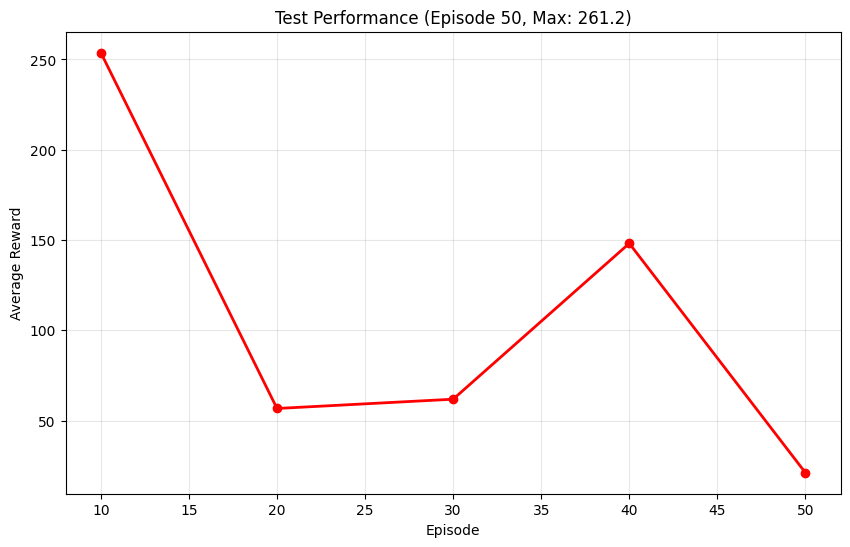

  5%|▌         | 52/1000 [42:37<14:32:04, 55.19s/it]

Training Batch 51: Collected 1000 timesteps, 2 episodes


  5%|▌         | 53/1000 [43:21<13:37:42, 51.81s/it]

Training Batch 52: Collected 1000 timesteps, 2 episodes


  5%|▌         | 54/1000 [44:05<12:59:53, 49.46s/it]

Training Batch 53: Collected 1000 timesteps, 2 episodes


  6%|▌         | 55/1000 [44:50<12:38:30, 48.16s/it]

Training Batch 54: Collected 1000 timesteps, 2 episodes


  6%|▌         | 56/1000 [45:34<12:16:45, 46.83s/it]

Training Batch 55: Collected 1000 timesteps, 2 episodes


  6%|▌         | 57/1000 [46:19<12:07:29, 46.29s/it]

Training Batch 56: Collected 1000 timesteps, 2 episodes


  6%|▌         | 58/1000 [47:03<11:57:04, 45.67s/it]

Training Batch 57: Collected 1000 timesteps, 2 episodes


  6%|▌         | 59/1000 [47:49<11:53:41, 45.51s/it]

Training Batch 58: Collected 1000 timesteps, 2 episodes


  6%|▌         | 60/1000 [48:33<11:46:03, 45.07s/it]

Training Batch 59: Collected 1000 timesteps, 2 episodes
Training Batch 60: Collected 1000 timesteps, 2 episodes


  6%|▌         | 61/1000 [49:45<13:53:38, 53.27s/it]

Episode 60: Avg Test Reward = 183.38, Max Test Reward = 205.03


  6%|▌         | 62/1000 [50:29<13:09:46, 50.52s/it]

Training Batch 61: Collected 1000 timesteps, 2 episodes


  6%|▋         | 63/1000 [51:14<12:43:08, 48.87s/it]

Training Batch 62: Collected 1000 timesteps, 2 episodes


  6%|▋         | 64/1000 [51:58<12:18:56, 47.37s/it]

Training Batch 63: Collected 1000 timesteps, 2 episodes


  6%|▋         | 65/1000 [52:43<12:05:00, 46.52s/it]

Training Batch 64: Collected 1000 timesteps, 2 episodes


  7%|▋         | 66/1000 [53:27<11:54:32, 45.90s/it]

Training Batch 65: Collected 1000 timesteps, 2 episodes


  7%|▋         | 67/1000 [54:12<11:49:00, 45.60s/it]

Training Batch 66: Collected 1000 timesteps, 2 episodes


  7%|▋         | 68/1000 [54:56<11:42:46, 45.24s/it]

Training Batch 67: Collected 1000 timesteps, 2 episodes


  7%|▋         | 69/1000 [55:42<11:43:00, 45.31s/it]

Training Batch 68: Collected 1000 timesteps, 2 episodes


  7%|▋         | 70/1000 [56:26<11:35:51, 44.89s/it]

Training Batch 69: Collected 1000 timesteps, 2 episodes
Training Batch 70: Collected 1000 timesteps, 2 episodes


  7%|▋         | 71/1000 [58:01<15:26:58, 59.87s/it]

Episode 70: Avg Test Reward = 107.94, Max Test Reward = 122.43


  7%|▋         | 72/1000 [58:45<14:14:16, 55.23s/it]

Training Batch 71: Collected 1000 timesteps, 2 episodes


  7%|▋         | 73/1000 [59:29<13:22:15, 51.93s/it]

Training Batch 72: Collected 1000 timesteps, 2 episodes


  7%|▋         | 74/1000 [1:00:14<12:49:47, 49.88s/it]

Training Batch 73: Collected 1000 timesteps, 2 episodes


  8%|▊         | 75/1000 [1:00:58<12:20:14, 48.02s/it]

Training Batch 74: Collected 1000 timesteps, 2 episodes


  8%|▊         | 76/1000 [1:01:43<12:04:02, 47.02s/it]

Training Batch 75: Collected 1000 timesteps, 2 episodes


  8%|▊         | 77/1000 [1:02:26<11:47:33, 45.99s/it]

Training Batch 76: Collected 1000 timesteps, 2 episodes


  8%|▊         | 78/1000 [1:03:12<11:43:45, 45.80s/it]

Training Batch 77: Collected 1000 timesteps, 2 episodes


  8%|▊         | 79/1000 [1:03:55<11:33:21, 45.17s/it]

Training Batch 78: Collected 1000 timesteps, 2 episodes


  8%|▊         | 80/1000 [1:04:40<11:31:09, 45.08s/it]

Training Batch 79: Collected 1000 timesteps, 2 episodes
Training Batch 80: Collected 1000 timesteps, 2 episodes


  8%|▊         | 81/1000 [1:06:14<15:14:42, 59.72s/it]

Episode 80: Avg Test Reward = 196.74, Max Test Reward = 245.17


  8%|▊         | 82/1000 [1:06:59<14:07:18, 55.38s/it]

Training Batch 81: Collected 1000 timesteps, 2 episodes


  8%|▊         | 83/1000 [1:07:43<13:14:56, 52.01s/it]

Training Batch 82: Collected 1000 timesteps, 2 episodes


  8%|▊         | 84/1000 [1:08:28<12:41:46, 49.90s/it]

Training Batch 83: Collected 1000 timesteps, 2 episodes


  8%|▊         | 85/1000 [1:09:13<12:17:21, 48.35s/it]

Training Batch 84: Collected 1000 timesteps, 2 episodes


  9%|▊         | 86/1000 [1:10:00<12:09:55, 47.92s/it]

Training Batch 85: Collected 1000 timesteps, 2 episodes


  9%|▊         | 87/1000 [1:10:49<12:13:12, 48.18s/it]

Training Batch 86: Collected 1000 timesteps, 2 episodes


  9%|▉         | 88/1000 [1:11:38<12:18:36, 48.59s/it]

Training Batch 87: Collected 1000 timesteps, 2 episodes


  9%|▉         | 89/1000 [1:12:26<12:14:12, 48.36s/it]

Training Batch 88: Collected 1000 timesteps, 2 episodes


  9%|▉         | 90/1000 [1:13:12<12:02:44, 47.65s/it]

Training Batch 89: Collected 1000 timesteps, 2 episodes
Training Batch 90: Collected 1000 timesteps, 2 episodes


/usr/local/lib/python3.11/dist-packages/highway_env/envs/common/observation.py:228: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = utils.lmap(df[feature], [f_range[0], f_range[1]], [-1, 1])
/usr/local/lib/python3.11/dist-packages/highway_env/envs/common/observation.py:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = np.clip(df[feature], -1, 1)
/usr/local/lib/python3.11/dist-packages/highway_env/envs/common/observation.py:228: SettingWithCopyWarning: 
A value is trying to be set 

Episode 90: Avg Test Reward = 150.97, Max Test Reward = 243.15


  9%|▉         | 92/1000 [1:15:34<14:26:09, 57.24s/it]

Training Batch 91: Collected 1000 timesteps, 2 episodes


  9%|▉         | 93/1000 [1:16:19<13:31:24, 53.68s/it]

Training Batch 92: Collected 1000 timesteps, 2 episodes


  9%|▉         | 94/1000 [1:17:06<12:57:30, 51.49s/it]

Training Batch 93: Collected 1000 timesteps, 2 episodes


 10%|▉         | 95/1000 [1:17:50<12:26:21, 49.48s/it]

Training Batch 94: Collected 1000 timesteps, 2 episodes


 10%|▉         | 96/1000 [1:18:37<12:11:27, 48.55s/it]

Training Batch 95: Collected 1000 timesteps, 2 episodes


 10%|▉         | 97/1000 [1:19:21<11:50:31, 47.21s/it]

Training Batch 96: Collected 1000 timesteps, 2 episodes


 10%|▉         | 98/1000 [1:20:07<11:44:41, 46.87s/it]

Training Batch 97: Collected 1000 timesteps, 2 episodes


 10%|▉         | 99/1000 [1:20:52<11:34:07, 46.22s/it]

Training Batch 98: Collected 1000 timesteps, 2 episodes


 10%|█         | 100/1000 [1:21:37<11:28:23, 45.89s/it]

Training Batch 99: Collected 1000 timesteps, 2 episodes
Training Batch 100: Collected 1000 timesteps, 2 episodes
Episode 100: Avg Test Reward = 105.68, Max Test Reward = 107.49


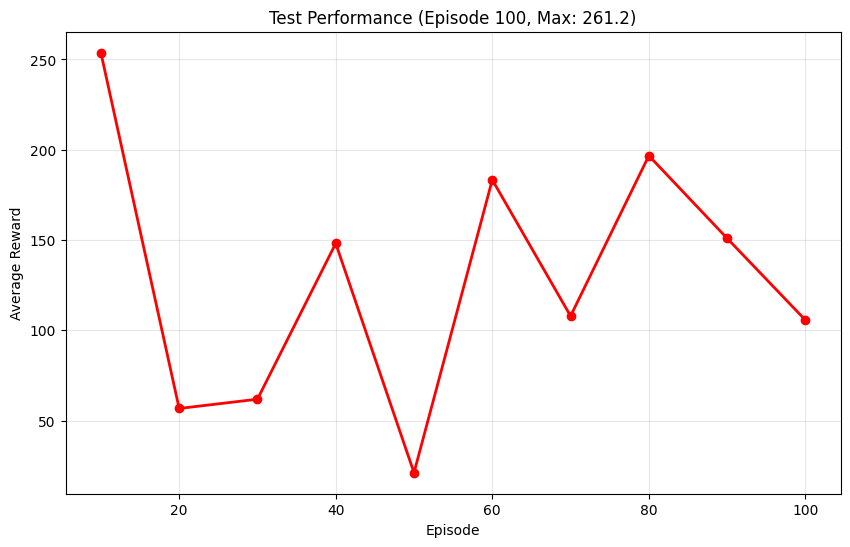

 10%|█         | 102/1000 [1:23:58<14:01:00, 56.19s/it]

Training Batch 101: Collected 1000 timesteps, 2 episodes


 10%|█         | 103/1000 [1:24:42<13:06:51, 52.63s/it]

Training Batch 102: Collected 1000 timesteps, 2 episodes


 10%|█         | 104/1000 [1:25:28<12:33:54, 50.49s/it]

Training Batch 103: Collected 1000 timesteps, 2 episodes


 10%|█         | 105/1000 [1:26:12<12:05:39, 48.65s/it]

Training Batch 104: Collected 1000 timesteps, 2 episodes


 11%|█         | 106/1000 [1:26:58<11:52:55, 47.85s/it]

Training Batch 105: Collected 1000 timesteps, 2 episodes


 11%|█         | 107/1000 [1:27:43<11:39:12, 46.98s/it]

Training Batch 106: Collected 1000 timesteps, 2 episodes


 11%|█         | 108/1000 [1:28:30<11:40:08, 47.09s/it]

Training Batch 107: Collected 1000 timesteps, 2 episodes


 11%|█         | 109/1000 [1:29:18<11:42:50, 47.33s/it]

Training Batch 108: Collected 1000 timesteps, 2 episodes


 11%|█         | 110/1000 [1:30:04<11:35:45, 46.90s/it]

Training Batch 109: Collected 1000 timesteps, 2 episodes
Training Batch 110: Collected 1000 timesteps, 2 episodes


 11%|█         | 111/1000 [1:31:42<15:21:12, 62.17s/it]

Episode 110: Avg Test Reward = 149.75, Max Test Reward = 170.93


 11%|█         | 112/1000 [1:32:28<14:09:45, 57.42s/it]

Training Batch 111: Collected 1000 timesteps, 2 episodes


 11%|█▏        | 113/1000 [1:33:14<13:17:44, 53.96s/it]

Training Batch 112: Collected 1000 timesteps, 2 episodes


 11%|█▏        | 114/1000 [1:34:01<12:43:00, 51.67s/it]

Training Batch 113: Collected 1000 timesteps, 2 episodes


 12%|█▏        | 115/1000 [1:34:46<12:13:09, 49.71s/it]

Training Batch 114: Collected 1000 timesteps, 2 episodes


 12%|█▏        | 116/1000 [1:35:32<11:56:29, 48.63s/it]

Training Batch 115: Collected 1000 timesteps, 2 episodes


 12%|█▏        | 117/1000 [1:36:17<11:40:24, 47.59s/it]

Training Batch 116: Collected 1000 timesteps, 2 episodes


 12%|█▏        | 118/1000 [1:37:03<11:32:10, 47.09s/it]

Training Batch 117: Collected 1000 timesteps, 2 episodes


 12%|█▏        | 119/1000 [1:37:48<11:21:13, 46.39s/it]

Training Batch 118: Collected 1000 timesteps, 2 episodes


 12%|█▏        | 120/1000 [1:38:33<11:18:07, 46.24s/it]

Training Batch 119: Collected 1000 timesteps, 2 episodes
Training Batch 120: Collected 1000 timesteps, 2 episodes


 12%|█▏        | 121/1000 [1:40:08<14:51:37, 60.86s/it]

Episode 120: Avg Test Reward = 172.64, Max Test Reward = 243.14


 12%|█▏        | 122/1000 [1:40:54<13:42:13, 56.19s/it]

Training Batch 121: Collected 1000 timesteps, 2 episodes


 12%|█▏        | 123/1000 [1:41:38<12:47:38, 52.52s/it]

Training Batch 122: Collected 1000 timesteps, 2 episodes


 12%|█▏        | 124/1000 [1:42:23<12:15:51, 50.40s/it]

Training Batch 123: Collected 1000 timesteps, 2 episodes


 12%|█▎        | 125/1000 [1:43:07<11:47:07, 48.49s/it]

Training Batch 124: Collected 1000 timesteps, 2 episodes


 13%|█▎        | 126/1000 [1:43:52<11:31:08, 47.45s/it]

Training Batch 125: Collected 1000 timesteps, 2 episodes


 13%|█▎        | 127/1000 [1:44:36<11:14:02, 46.33s/it]

Training Batch 126: Collected 1000 timesteps, 2 episodes


 13%|█▎        | 128/1000 [1:45:21<11:06:12, 45.84s/it]

Training Batch 127: Collected 1000 timesteps, 2 episodes


 13%|█▎        | 129/1000 [1:46:04<10:55:03, 45.12s/it]

Training Batch 128: Collected 1000 timesteps, 2 episodes


 13%|█▎        | 130/1000 [1:46:49<10:53:05, 45.04s/it]

Training Batch 129: Collected 1000 timesteps, 2 episodes
Training Batch 130: Collected 1000 timesteps, 2 episodes


 13%|█▎        | 131/1000 [1:48:22<14:23:06, 59.59s/it]

Episode 130: Avg Test Reward = 151.69, Max Test Reward = 244.59


 13%|█▎        | 132/1000 [1:49:07<13:17:14, 55.11s/it]

Training Batch 131: Collected 1000 timesteps, 2 episodes


 13%|█▎        | 133/1000 [1:49:52<12:33:01, 52.11s/it]

Training Batch 132: Collected 1000 timesteps, 2 episodes


 13%|█▎        | 134/1000 [1:50:36<11:55:36, 49.58s/it]

Training Batch 133: Collected 1000 timesteps, 2 episodes


 14%|█▎        | 135/1000 [1:51:20<11:32:25, 48.03s/it]

Training Batch 134: Collected 1000 timesteps, 2 episodes


 14%|█▎        | 136/1000 [1:52:04<11:13:44, 46.79s/it]

Training Batch 135: Collected 1000 timesteps, 2 episodes


 14%|█▎        | 137/1000 [1:52:49<11:05:06, 46.24s/it]

Training Batch 136: Collected 1000 timesteps, 2 episodes


 14%|█▍        | 138/1000 [1:53:33<10:52:14, 45.40s/it]

Training Batch 137: Collected 1000 timesteps, 2 episodes


 14%|█▍        | 139/1000 [1:54:17<10:49:07, 45.24s/it]

Training Batch 138: Collected 1000 timesteps, 2 episodes


 14%|█▍        | 140/1000 [1:55:01<10:41:21, 44.75s/it]

Training Batch 139: Collected 1000 timesteps, 2 episodes
Training Batch 140: Collected 1000 timesteps, 2 episodes


 14%|█▍        | 141/1000 [1:56:34<14:07:45, 59.21s/it]

Episode 140: Avg Test Reward = 151.21, Max Test Reward = 244.44


 14%|█▍        | 142/1000 [1:57:19<13:05:06, 54.90s/it]

Training Batch 141: Collected 1000 timesteps, 2 episodes


 14%|█▍        | 143/1000 [1:58:02<12:13:52, 51.38s/it]

Training Batch 142: Collected 1000 timesteps, 2 episodes


 14%|█▍        | 144/1000 [1:58:47<11:47:28, 49.59s/it]

Training Batch 143: Collected 1000 timesteps, 2 episodes


 14%|█▍        | 145/1000 [1:59:31<11:22:02, 47.86s/it]

Training Batch 144: Collected 1000 timesteps, 2 episodes


 15%|█▍        | 146/1000 [2:00:16<11:08:37, 46.98s/it]

Training Batch 145: Collected 1000 timesteps, 2 episodes


 15%|█▍        | 147/1000 [2:01:00<10:53:33, 45.97s/it]

Training Batch 146: Collected 1000 timesteps, 2 episodes


 15%|█▍        | 148/1000 [2:01:45<10:48:35, 45.67s/it]

Training Batch 147: Collected 1000 timesteps, 2 episodes


 15%|█▍        | 149/1000 [2:02:29<10:41:00, 45.20s/it]

Training Batch 148: Collected 1000 timesteps, 2 episodes


 15%|█▌        | 150/1000 [2:03:14<10:38:05, 45.04s/it]

Training Batch 149: Collected 1000 timesteps, 2 episodes
Training Batch 150: Collected 1000 timesteps, 2 episodes
Episode 150: Avg Test Reward = 174.52, Max Test Reward = 247.52


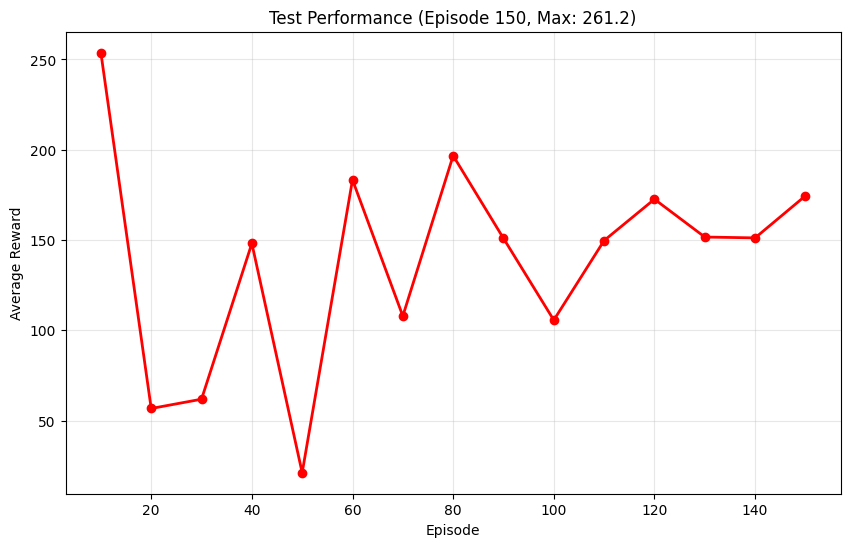

 15%|█▌        | 152/1000 [2:05:32<12:58:14, 55.06s/it]

Training Batch 151: Collected 1000 timesteps, 2 episodes


 15%|█▌        | 153/1000 [2:06:17<12:16:15, 52.16s/it]

Training Batch 152: Collected 1000 timesteps, 2 episodes


 15%|█▌        | 154/1000 [2:07:01<11:40:41, 49.69s/it]

Training Batch 153: Collected 1000 timesteps, 2 episodes


 16%|█▌        | 155/1000 [2:07:46<11:20:37, 48.33s/it]

Training Batch 154: Collected 1000 timesteps, 2 episodes


 16%|█▌        | 156/1000 [2:08:30<10:59:51, 46.91s/it]

Training Batch 155: Collected 1000 timesteps, 2 episodes


 16%|█▌        | 157/1000 [2:09:15<10:51:39, 46.38s/it]

Training Batch 156: Collected 1000 timesteps, 2 episodes


 16%|█▌        | 158/1000 [2:09:59<10:38:13, 45.48s/it]

Training Batch 157: Collected 1000 timesteps, 2 episodes


 16%|█▌        | 159/1000 [2:10:43<10:34:59, 45.30s/it]

Training Batch 158: Collected 1000 timesteps, 2 episodes


 16%|█▌        | 160/1000 [2:11:28<10:30:32, 45.04s/it]

Training Batch 159: Collected 1000 timesteps, 2 episodes
Training Batch 160: Collected 1000 timesteps, 2 episodes


 16%|█▌        | 161/1000 [2:13:04<14:03:29, 60.32s/it]

Episode 160: Avg Test Reward = 174.10, Max Test Reward = 245.18


 16%|█▌        | 162/1000 [2:13:48<12:55:10, 55.50s/it]

Training Batch 161: Collected 1000 timesteps, 2 episodes


 16%|█▋        | 163/1000 [2:14:34<12:15:51, 52.75s/it]

Training Batch 162: Collected 1000 timesteps, 2 episodes


 16%|█▋        | 164/1000 [2:15:19<11:40:51, 50.30s/it]

Training Batch 163: Collected 1000 timesteps, 2 episodes


 16%|█▋        | 165/1000 [2:16:05<11:21:59, 49.01s/it]

Training Batch 164: Collected 1000 timesteps, 2 episodes


 17%|█▋        | 166/1000 [2:16:49<11:00:44, 47.54s/it]

Training Batch 165: Collected 1000 timesteps, 2 episodes


 17%|█▋        | 167/1000 [2:17:34<10:49:34, 46.79s/it]

Training Batch 166: Collected 1000 timesteps, 2 episodes


 17%|█▋        | 168/1000 [2:18:19<10:38:56, 46.08s/it]

Training Batch 167: Collected 1000 timesteps, 2 episodes


 17%|█▋        | 169/1000 [2:19:04<10:33:58, 45.77s/it]

Training Batch 168: Collected 1000 timesteps, 2 episodes


 17%|█▋        | 170/1000 [2:19:48<10:26:30, 45.29s/it]

Training Batch 169: Collected 1000 timesteps, 2 episodes
Training Batch 170: Collected 1000 timesteps, 2 episodes


 17%|█▋        | 171/1000 [2:21:22<13:49:14, 60.02s/it]

Episode 170: Avg Test Reward = 200.75, Max Test Reward = 249.18


 17%|█▋        | 172/1000 [2:22:07<12:44:45, 55.42s/it]

Training Batch 171: Collected 1000 timesteps, 2 episodes


 17%|█▋        | 173/1000 [2:22:51<11:56:26, 51.98s/it]

Training Batch 172: Collected 1000 timesteps, 2 episodes


 17%|█▋        | 174/1000 [2:23:36<11:26:37, 49.88s/it]

Training Batch 173: Collected 1000 timesteps, 2 episodes


 18%|█▊        | 175/1000 [2:24:19<10:58:45, 47.91s/it]

Training Batch 174: Collected 1000 timesteps, 2 episodes


 18%|█▊        | 176/1000 [2:25:04<10:47:01, 47.11s/it]

Training Batch 175: Collected 1000 timesteps, 2 episodes


 18%|█▊        | 177/1000 [2:25:49<10:34:58, 46.29s/it]

Training Batch 176: Collected 1000 timesteps, 2 episodes


 18%|█▊        | 178/1000 [2:26:34<10:28:59, 45.91s/it]

Training Batch 177: Collected 1000 timesteps, 2 episodes


 18%|█▊        | 179/1000 [2:27:17<10:18:22, 45.19s/it]

Training Batch 178: Collected 1000 timesteps, 2 episodes


/usr/local/lib/python3.11/dist-packages/highway_env/envs/common/observation.py:228: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = utils.lmap(df[feature], [f_range[0], f_range[1]], [-1, 1])
 18%|█▊        | 180/1000 [2:28:02<10:15:33, 45.04s/it]

Training Batch 179: Collected 1000 timesteps, 2 episodes
Training Batch 180: Collected 1000 timesteps, 2 episodes


 18%|█▊        | 181/1000 [2:29:35<13:32:45, 59.54s/it]

Episode 180: Avg Test Reward = 62.85, Max Test Reward = 164.18


 18%|█▊        | 182/1000 [2:30:19<12:28:03, 54.87s/it]

Training Batch 181: Collected 1000 timesteps, 2 episodes


 18%|█▊        | 183/1000 [2:31:04<11:46:39, 51.90s/it]

Training Batch 182: Collected 1000 timesteps, 2 episodes


 18%|█▊        | 184/1000 [2:31:48<11:11:28, 49.37s/it]

Training Batch 183: Collected 1000 timesteps, 2 episodes


 18%|█▊        | 185/1000 [2:32:32<10:51:44, 47.98s/it]

Training Batch 184: Collected 1000 timesteps, 2 episodes


 19%|█▊        | 186/1000 [2:33:16<10:34:02, 46.74s/it]

Training Batch 185: Collected 1000 timesteps, 2 episodes


 19%|█▊        | 187/1000 [2:34:00<10:22:37, 45.95s/it]

Training Batch 186: Collected 1000 timesteps, 2 episodes


 19%|█▉        | 188/1000 [2:34:44<10:11:24, 45.18s/it]

Training Batch 187: Collected 1000 timesteps, 2 episodes


 19%|█▉        | 189/1000 [2:35:27<10:03:05, 44.62s/it]

Training Batch 188: Collected 1000 timesteps, 2 episodes


 19%|█▉        | 190/1000 [2:36:12<10:03:02, 44.67s/it]

Training Batch 189: Collected 1000 timesteps, 2 episodes
Training Batch 190: Collected 1000 timesteps, 2 episodes


 19%|█▉        | 191/1000 [2:37:45<13:18:24, 59.21s/it]

Episode 190: Avg Test Reward = 11.54, Max Test Reward = 11.90


 19%|█▉        | 192/1000 [2:38:30<12:18:32, 54.84s/it]

Training Batch 191: Collected 1000 timesteps, 2 episodes


 19%|█▉        | 193/1000 [2:39:14<11:33:12, 51.54s/it]

Training Batch 192: Collected 1000 timesteps, 2 episodes


 19%|█▉        | 194/1000 [2:39:58<11:03:17, 49.38s/it]

Training Batch 193: Collected 1000 timesteps, 2 episodes


 20%|█▉        | 195/1000 [2:40:42<10:41:11, 47.79s/it]

Training Batch 194: Collected 1000 timesteps, 2 episodes


 20%|█▉        | 196/1000 [2:41:26<10:23:36, 46.54s/it]

Training Batch 195: Collected 1000 timesteps, 2 episodes


 20%|█▉        | 197/1000 [2:42:10<10:13:29, 45.84s/it]

Training Batch 196: Collected 1000 timesteps, 2 episodes


 20%|█▉        | 198/1000 [2:42:53<10:02:49, 45.10s/it]

Training Batch 197: Collected 1000 timesteps, 2 episodes


 20%|█▉        | 199/1000 [2:43:38<9:59:38, 44.92s/it] 

Training Batch 198: Collected 1000 timesteps, 2 episodes


/usr/local/lib/python3.11/dist-packages/highway_env/envs/common/observation.py:228: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = utils.lmap(df[feature], [f_range[0], f_range[1]], [-1, 1])
/usr/local/lib/python3.11/dist-packages/highway_env/envs/common/observation.py:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = np.clip(df[feature], -1, 1)
/usr/local/lib/python3.11/dist-packages/highway_env/envs/common/observation.py:228: SettingWithCopyWarning: 
A value is trying to be set 

Training Batch 199: Collected 1000 timesteps, 2 episodes
Training Batch 200: Collected 1000 timesteps, 2 episodes
Episode 200: Avg Test Reward = 95.22, Max Test Reward = 169.01


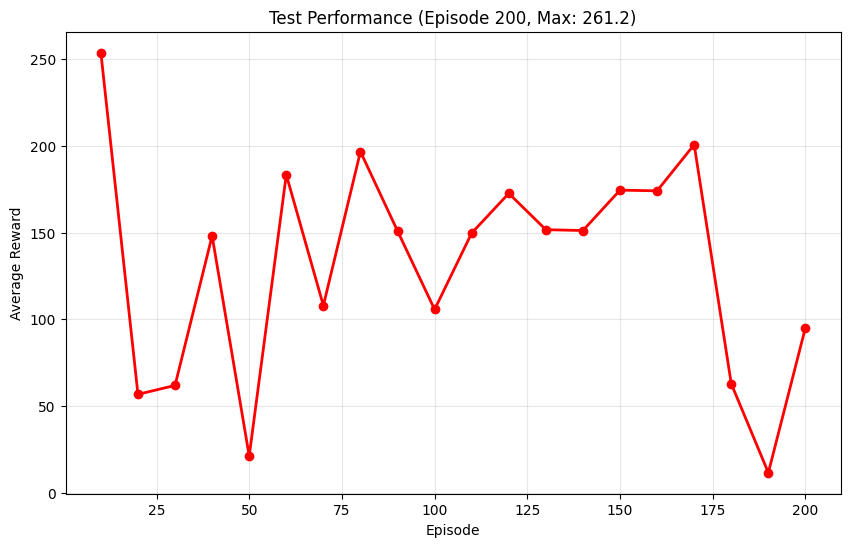

 20%|██        | 202/1000 [2:46:41<12:14:28, 55.22s/it]

Training Batch 201: Collected 1000 timesteps, 2 episodes


 20%|██        | 203/1000 [2:47:26<11:29:41, 51.92s/it]

Training Batch 202: Collected 1000 timesteps, 2 episodes


 20%|██        | 204/1000 [2:48:10<11:00:30, 49.79s/it]

Training Batch 203: Collected 1000 timesteps, 2 episodes


 20%|██        | 205/1000 [2:48:54<10:36:04, 48.01s/it]

Training Batch 204: Collected 1000 timesteps, 2 episodes


 21%|██        | 206/1000 [2:49:40<10:24:38, 47.20s/it]

Training Batch 205: Collected 1000 timesteps, 2 episodes


 21%|██        | 207/1000 [2:50:24<10:11:33, 46.27s/it]

Training Batch 206: Collected 1000 timesteps, 2 episodes


 21%|██        | 208/1000 [2:51:09<10:05:17, 45.86s/it]

Training Batch 207: Collected 1000 timesteps, 2 episodes


 21%|██        | 209/1000 [2:51:52<9:56:48, 45.27s/it] 

Training Batch 208: Collected 1000 timesteps, 2 episodes


/usr/local/lib/python3.11/dist-packages/highway_env/envs/common/observation.py:228: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = utils.lmap(df[feature], [f_range[0], f_range[1]], [-1, 1])
/usr/local/lib/python3.11/dist-packages/highway_env/envs/common/observation.py:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = np.clip(df[feature], -1, 1)
/usr/local/lib/python3.11/dist-packages/highway_env/envs/common/observation.py:228: SettingWithCopyWarning: 
A value is trying to be set 

Training Batch 209: Collected 1000 timesteps, 2 episodes
Training Batch 210: Collected 1000 timesteps, 2 episodes


 21%|██        | 211/1000 [2:54:10<13:03:34, 59.59s/it]

Episode 210: Avg Test Reward = 73.79, Max Test Reward = 105.39


 21%|██        | 212/1000 [2:54:55<12:03:11, 55.07s/it]

Training Batch 211: Collected 1000 timesteps, 2 episodes


 21%|██▏       | 213/1000 [2:55:40<11:22:47, 52.06s/it]

Training Batch 212: Collected 1000 timesteps, 2 episodes


 21%|██▏       | 214/1000 [2:56:24<10:50:32, 49.66s/it]

Training Batch 213: Collected 1000 timesteps, 2 episodes


 22%|██▏       | 215/1000 [2:57:08<10:29:03, 48.08s/it]

Training Batch 214: Collected 1000 timesteps, 2 episodes


 22%|██▏       | 216/1000 [2:57:52<10:11:25, 46.79s/it]

Training Batch 215: Collected 1000 timesteps, 2 episodes


 22%|██▏       | 217/1000 [2:58:38<10:05:36, 46.41s/it]

Training Batch 216: Collected 1000 timesteps, 2 episodes


 22%|██▏       | 218/1000 [2:59:22<9:55:52, 45.72s/it] 

Training Batch 217: Collected 1000 timesteps, 2 episodes


 22%|██▏       | 219/1000 [3:00:07<9:51:42, 45.46s/it]

Training Batch 218: Collected 1000 timesteps, 2 episodes


 22%|██▏       | 220/1000 [3:00:51<9:45:14, 45.02s/it]

Training Batch 219: Collected 1000 timesteps, 2 episodes
Training Batch 220: Collected 1000 timesteps, 2 episodes


 22%|██▏       | 221/1000 [3:02:26<13:00:39, 60.13s/it]

Episode 220: Avg Test Reward = 73.92, Max Test Reward = 107.33


 22%|██▏       | 222/1000 [3:03:12<12:02:46, 55.74s/it]

Training Batch 221: Collected 1000 timesteps, 2 episodes


 22%|██▏       | 223/1000 [3:03:57<11:20:11, 52.52s/it]

Training Batch 222: Collected 1000 timesteps, 2 episodes


 22%|██▏       | 224/1000 [3:04:40<10:45:54, 49.94s/it]

Training Batch 223: Collected 1000 timesteps, 2 episodes


 22%|██▎       | 225/1000 [3:05:25<10:25:40, 48.44s/it]

Training Batch 224: Collected 1000 timesteps, 2 episodes


 23%|██▎       | 226/1000 [3:06:09<10:06:24, 47.01s/it]

Training Batch 225: Collected 1000 timesteps, 2 episodes


 23%|██▎       | 227/1000 [3:06:53<9:54:03, 46.11s/it] 

Training Batch 226: Collected 1000 timesteps, 2 episodes


 23%|██▎       | 228/1000 [3:07:37<9:44:06, 45.40s/it]

Training Batch 227: Collected 1000 timesteps, 2 episodes


 23%|██▎       | 229/1000 [3:08:20<9:35:57, 44.82s/it]

Training Batch 228: Collected 1000 timesteps, 2 episodes


In [ ]:
# Fixed PPO Training Loop with proper variable definitions and imports

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

# Fix numpy compatibility
if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_

class ActorCritic(nn.Module):
    def __init__(self, state_dim=8, action_dim=1, hidden_size=128):
        super().__init__()

        self.network = nn.Sequential(
            nn.Linear(state_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU()
        )

        # Policy head (actor) - outputs logits for action distribution
        self.actor = nn.Linear(hidden_size, action_dim)

        # Value head (critic)
        self.critic = nn.Linear(hidden_size, 1)

    def forward(self, x):
        features = self.network(x)
        return self.actor(features), self.critic(features)

# Define hyperparameters
T = 1000  # Max timesteps per rollout
K = 10    # Number of policy update epochs
batch_size = 64
gamma = 0.99
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vf_coeff_cl = 0.5
ent_coef_c2 = 0.01
nb_episodes = 1000
epsilon = 0.2
gae_lambda = 0.99
max_episodes_per_rollout = 10

# Define action dimension (continuous action space)
action_dim = 1  # For lateral acceleration
state_dim = 8   # Based on your agent state

# Initialize model and optimizer
model = ActorCritic(state_dim=state_dim, action_dim=action_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Tracking variables
total_env_episodes = 0
max_reward = float('-inf')
batch_average_reward_history = []
batch_episode_history = []
individual_test_rewards = []
individual_test_episodes = []

# Training loop
for episode in tqdm.tqdm(range(nb_episodes)):
    # PPO Initialization
    advantages = torch.zeros(T, dtype=torch.float32, device=device)
    buffer_states = torch.zeros((T, state_dim), dtype=torch.float32, device=device)
    buffer_actions = torch.zeros((T, action_dim), dtype=torch.float32, device=device)
    buffer_log_probs = torch.zeros((T), dtype=torch.float32, device=device)
    buffer_state_values = torch.zeros((T+1), dtype=torch.float32, device=device)
    buffer_rewards = torch.zeros((T), dtype=torch.float32, device=device)
    buffer_is_terminal = torch.zeros((T), dtype=torch.float32, device=device)

    # Episode control variables
    episodes_completed_in_rollout = 0
    t = 0  # Actual timesteps collected

    # Env Initialization
    obs, _ = env.reset()
    state_manager = ENV(obs, 0.0)

    # IDM Initialization
    ego_state_idm = state_manager.ego_state_idm()
    lead_state = state_manager.longitudinal_lead_state()

    # Initialize target_id
    target_id = env.unwrapped.vehicle.lane_index[-1]
    agent_state = state_manager.ego_state_agent(target_id=target_id)

    # Update IDM inputs based on initial state
    gap = lead_state['x']
    delta_velocity = lead_state['vx']
    input_variables = [gap, ego_state_idm['vx'], delta_velocity]

    episode_step = 0
    episode_return = 0.0
    done = False
    obs_old = obs

    # Collect trajectories with dual stopping condition
    while t < T and episodes_completed_in_rollout < max_episodes_per_rollout:

        gap_control = Gap_Controller(obs, following_gap_threshold=30)
        activated_target_lane = gap_control.lane_checker()

        # Determine target lane
        target_id = activated_target_lane
        agent_state = state_manager.ego_state_agent(target_id=target_id)

        # Convert agent state dict to tensor
        state_tensor = torch.tensor(
            [agent_state[key] for key in ['vx', 'longitudinal_acceleration', 'x', 'y', 'thetha', 'lane_id', 'lane_width', 'self_curvature']],
            dtype=torch.float32, device=device
        ).unsqueeze(0)

        # Get action and value from model
        with torch.no_grad():
            action_logits, value = model(state_tensor)

        action_logits, value = action_logits.squeeze(0), value.squeeze(0)

        # For continuous action space, use Normal distribution
        action_mean = torch.tanh(action_logits)  # Keep actions in reasonable range
        action_std = torch.ones_like(action_mean) * 0.1  # Fixed std for simplicity
        m = torch.distributions.Normal(action_mean, action_std)

        # Sample action
        agent_action = m.sample()
        log_prob = m.log_prob(agent_action).sum()  # Sum for multi-dimensional actions

        # IDM Action
        idm_acceleration = ego_vehicle_idm.longitudinal_controller(input_variables)
        longitudinal_control = idm_acceleration

        # Transform agent action to steering angle
        lateral_control = state_manager.steering_angle(agent_action.item(), L)

        # Combine longitudinal and lateral actions
        action = [longitudinal_control, lateral_control]

        # Take action in environment
        obs, reward, done, truncated, info = env.step(action)
        done = done or truncated

        # Update state manager with new observation and applied longitudinal control
        state_manager = ENV(obs, longitudinal_control)

        # Compute reward based on the new state
        reward_components = state_manager.reward_function(obs_old, obs, target_id)
        reward = reward_components[0]

        # Update episode return
        episode_return += reward

        # Store trajectory information
        buffer_states[t] = state_tensor.squeeze(0)
        buffer_actions[t] = agent_action
        buffer_log_probs[t] = log_prob
        buffer_state_values[t] = value
        buffer_rewards[t] = torch.tensor(reward, dtype=torch.float32, device=device)
        buffer_is_terminal[t] = done
        t += 1  # Increment timestep counter
        obs_old = obs

        # Update IDM inputs for next iteration
        ego_state_idm = state_manager.ego_state_idm()
        lead_state = state_manager.longitudinal_lead_state()
        gap = lead_state['x']
        delta_velocity = lead_state['vx']
        input_variables = [gap, ego_state_idm['vx'], delta_velocity]

        # If episode is done, track results and increment episode counter
        if done:
            episodes_completed_in_rollout += 1
            total_env_episodes += 1

            # Reset environment if more episodes needed
            if episodes_completed_in_rollout < max_episodes_per_rollout and t < T:
                obs, _ = env.reset()
                state_manager = ENV(obs, 0.0)
                ego_state_idm = state_manager.ego_state_idm()
                lead_state = state_manager.longitudinal_lead_state()
                target_id = env.unwrapped.vehicle.lane_index[-1]
                gap = lead_state['x']
                delta_velocity = lead_state['vx']
                input_variables = [gap, ego_state_idm['vx'], delta_velocity]
                obs_old = obs
                done = False

    # Actual number of timesteps collected
    actual_T = t

    # Get final value for bootstrapping
    if not done and actual_T > 0:
        target_id = env.unwrapped.vehicle.lane_index[-1]
        agent_state = state_manager.ego_state_agent(target_id=target_id)
        final_state_tensor = torch.tensor(
            [agent_state[key] for key in ['vx', 'longitudinal_acceleration', 'x', 'y', 'thetha', 'lane_id', 'lane_width', 'self_curvature']],
            dtype=torch.float32, device=device
        ).unsqueeze(0)

        with torch.no_grad():
            _, final_value = model(final_state_tensor)
        buffer_state_values[actual_T] = final_value.squeeze(0)

    # Calculate advantages using GAE
    gae = 0
    advantages = torch.zeros(actual_T, dtype=torch.float32, device=device)

    for t_idx in range(actual_T-1, -1, -1):
        if buffer_is_terminal[t_idx]:
            terminal = 1
            next_value = 0
        else:
            terminal = 0
            if t_idx == actual_T-1:
                next_value = buffer_state_values[actual_T]
            else:
                next_value = buffer_state_values[t_idx+1]

        delta = buffer_rewards[t_idx] + gamma * next_value * (1-terminal) - buffer_state_values[t_idx]
        gae = delta + (gamma * gae_lambda) * gae * (1-terminal)
        advantages[t_idx] = gae

    # Normalize advantages
    if actual_T > 1:
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

    # Prepare data for policy update
    advantages_data_loader = DataLoader(
        TensorDataset(
            advantages.detach(),
            buffer_states[:actual_T].detach(),
            buffer_actions[:actual_T].detach(),
            buffer_log_probs[:actual_T].detach(),
            buffer_state_values[:actual_T].detach()),
        batch_size=min(batch_size, actual_T),
        shuffle=True)

    # Policy update (K epochs)
    for epoch in range(K):
        for batch_data in advantages_data_loader:
            b_adv, obs_batch, action_batch, old_log_probs, old_state_values = batch_data

            # Forward pass
            action_logits, value = model(obs_batch)
            action_mean = torch.tanh(action_logits)
            action_std = torch.ones_like(action_mean) * 0.1
            m = torch.distributions.Normal(action_mean, action_std)
            log_probs = m.log_prob(action_batch).sum(dim=-1)

            # Calculate ratio
            ratio = torch.exp(log_probs - old_log_probs)
            returns = b_adv + old_state_values

            # Calculate policy loss with clipping
            policy_loss_1 = b_adv * ratio
            clip_range = epsilon
            policy_loss_2 = b_adv * torch.clamp(ratio, 1-clip_range, 1+clip_range)
            policy_loss = -torch.min(policy_loss_1, policy_loss_2).mean()

            # Calculate value loss
            value_loss = F.mse_loss(returns, value.squeeze())

            # Calculate entropy loss
            entropy_loss = -(m.entropy()).mean()

            # Combined loss
            loss = policy_loss + vf_coeff_cl * value_loss + ent_coef_c2 * entropy_loss

            # Optimize
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()

    # Print rollout info
    print(f"Training Batch {episode}: Collected {actual_T} timesteps, {episodes_completed_in_rollout} episodes")

    # Testing every 10 episodes
    if episode % 10 == 0 and episode > 0:
        test_rewards = []

        for test_ep in range(3):  # Reduced to 3 test episodes for speed
            obs, _ = env.reset()
            state_manager = ENV(obs, 0.0)
            episode_reward = 0
            done = False
            test_steps = 0

            while not done and test_steps < 500:  # Limit test episode length
                target_id = env.unwrapped.vehicle.lane_index[-1]
                agent_state = state_manager.ego_state_agent(target_id=target_id)

                state_tensor = torch.tensor(
                    [agent_state[key] for key in ['vx', 'longitudinal_acceleration', 'x', 'y', 'thetha', 'lane_id', 'lane_width', 'self_curvature']],
                    dtype=torch.float32, device=device
                ).unsqueeze(0)

                with torch.no_grad():
                    action_logits, _ = model(state_tensor)

                # Deterministic action selection
                action_mean = torch.tanh(action_logits)
                agent_action = action_mean.squeeze(0)

                # IDM control
                ego_state_idm = state_manager.ego_state_idm()
                lead_state = state_manager.longitudinal_lead_state()
                input_variables = [lead_state['x'], ego_state_idm['vx'], lead_state['vx']]
                idm_acceleration = ego_vehicle_idm.longitudinal_controller(input_variables)

                lateral_control = state_manager.steering_angle(agent_action.item(), L)
                action = [idm_acceleration, lateral_control]

                obs, reward, done, truncated, info = env.step(action)
                done = done or truncated
                state_manager = ENV(obs, idm_acceleration)

                episode_reward += reward
                test_steps += 1

            test_rewards.append(episode_reward)

        avg_test_reward = sum(test_rewards) / len(test_rewards)
        current_max = max(test_rewards)

        if current_max > max_reward:
            max_reward = current_max

        batch_average_reward_history.append(avg_test_reward)
        batch_episode_history.append(episode)

        print(f"Episode {episode}: Avg Test Reward = {avg_test_reward:.2f}, Max Test Reward = {current_max:.2f}")

    # Plot every 50 episodes
    if episode % 50 == 0 and episode > 0 and batch_average_reward_history:
        plt.figure(figsize=(10, 6))
        plt.plot(batch_episode_history, batch_average_reward_history, 'r-o', linewidth=2)
        plt.title(f"Test Performance (Episode {episode}, Max: {max_reward:.1f})")
        plt.xlabel("Episode")
        plt.ylabel("Average Reward")
        plt.grid(True, alpha=0.3)
        plt.show()

print("Training completed!")